In [1]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn.metrics as metrics

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical


%matplotlib inline

In [2]:
flowers = glob.glob('./data/flr_*.jpg')
fungus = glob.glob('./data/fgs_*.jpg')
rocks = glob.glob('./data/rck_*.jpg')

pixel_flowers = glob.glob('./data/pxl_flower_*.jpeg')
pixel_umbrella = glob.glob('./data/pxl_umbrella_*.jpeg')

flowers102 = glob.glob('./data/jpg/image_*.jpg')

open_image_mushroom = glob.glob('./data/Open_Image/Mushroom/*.jpg')
open_image_umbrella = glob.glob('./data/Open_Image/Umbrella/*.jpg')
print("There are %s+%s+%s flower, %s+%s fungus, %s rock and %s+%s umbrella pictures" 
      %(len(flowers), len(pixel_flowers), len(flowers102), 
        len(fungus), len(open_image_mushroom), len(rocks), 
        len(pixel_umbrella), len(open_image_umbrella)))

There are 1269+1792+8189 flower, 856+1782 fungus, 1007 rock and 420+3357 umbrella pictures


Showing: ./data\flr_00139.jpg


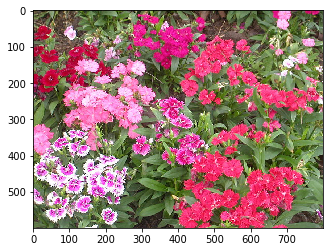

Showing: ./data\flr_01035.jpg


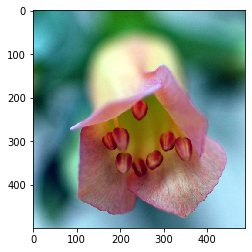

Showing: ./data\flr_00911.jpg


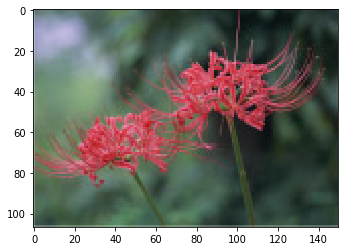

Showing: ./data\flr_01552.jpg


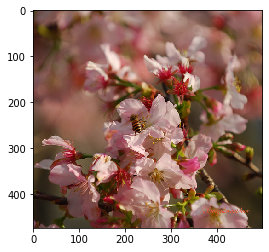

Showing: ./data\flr_01916.jpg


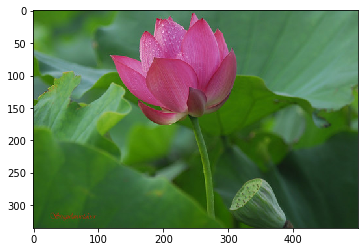

In [3]:
# Randomly show 10 examples of the images
from IPython.display import Image
    
dataset = flowers #flowers #fungus #rocks

for i in range(0, 5):
    index = random.randint(0, len(dataset)-1)   
    print("Showing:", dataset[index])
    
    img = mpimg.imread(dataset[index])
    imgplot = plt.imshow(img)
    plt.show()

#Image(dataset[index])

In [4]:
# OPTIONS

pixel_size = 224
additional_data = True

In [6]:
# Load the data
flrDat = np.load('./npz/flr-imgs' + str(pixel_size) + '.npz')['arr_0']
pxlflrDat = np.load('./npz/pxl_flr-imgs' + str(pixel_size) + '.npz')['arr_0']

if additional_data == True:
    flr102Dat = np.load('./npz/flr102-imgs' + str(pixel_size) + '.npz')['arr_0']

fgsDat = np.load('./npz/fgs-imgs' + str(pixel_size) + '.npz')['arr_0']
rckDat = np.load('./npz/rck-imgs' + str(pixel_size) + '.npz')['arr_0']
pxlumbDat = np.load('./npz/pxl_umb-imgs' + str(pixel_size) + '.npz')['arr_0']

if additional_data == True:
    OpnImgfgsDat = np.load('./npz/fgsOpnImg-imgs' + str(pixel_size) + '.npz')['arr_0']
    OpnImgumbDat = np.load('./npz/umbOpnImg-imgs' + str(pixel_size) + '.npz')['arr_0']

In [1]:
print("For the original datasets:")
if additional_data == True:
    print("This is the larger dataset ~18k")
    print("The flower shapes are %s, %s, %s" \
          %(flrDat.shape, pxlflrDat.shape, flr102Dat.shape))

    print ("The non-flower shapes are %s, %s, %s, %s, %s" \
           %(fgsDat.shape, rckDat.shape, pxlumbDat.shape, OpnImgfgsDat.shape, OpnImgumbDat.shape))
else:
    print("This is the smaller dataset ~5k")
    print("The flower shapes are %s, %s" \
          %(flrDat.shape, pxlflrDat.shape))

    print ("The non-flower shapes are %s, %s, %s" \
           %(fgsDat.shape, rckDat.shape, pxlumbDat.shape))

For the original datasets:


NameError: name 'additional_data' is not defined

In [8]:
if additional_data == True:
    allflrDat = np.vstack((flrDat, pxlflrDat, flr102Dat))
else:
    allflrDat = np.vstack((flrDat, pxlflrDat))

In [9]:
if additional_data == True:
    allnonflrDat = np.vstack((pxlumbDat, fgsDat, rckDat, OpnImgfgsDat, OpnImgumbDat))
else:
    allnonflrDat = np.vstack((pxlumbDat, fgsDat, rckDat))

In [10]:
print("For the flower and non-flower datasets:")
print("The shapes are %s, %s" \
      %(allflrDat.shape, allnonflrDat.shape))

For the flower and non-flower datasets:
The shapes are (3061, 224, 224, 3), (2270, 224, 224, 3)


In [47]:
# Randomly shuffle each set
np.random.RandomState(10)
np.random.shuffle(allflrDat)
np.random.shuffle(allnonflrDat)

Showing 0 index image


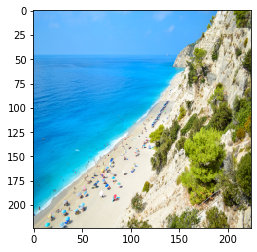

Showing 1 index image


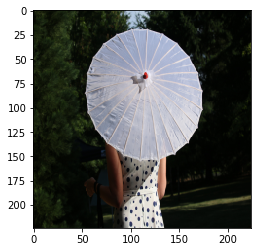

Showing 2 index image


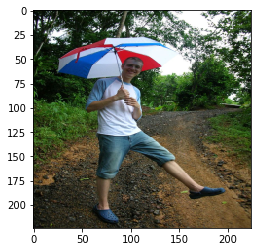

Showing 3 index image


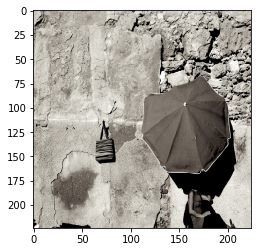

Showing 4 index image


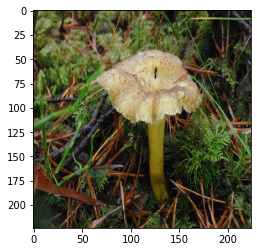

Showing 5 index image


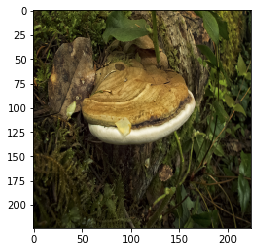

Showing 6 index image


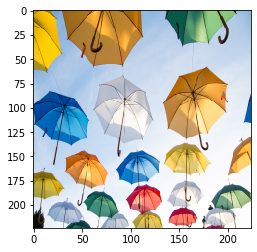

Showing 7 index image


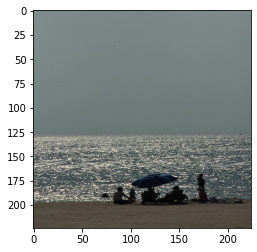

Showing 8 index image


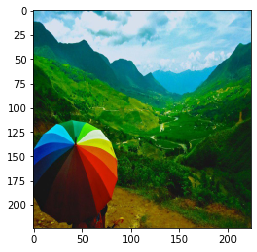

Showing 9 index image


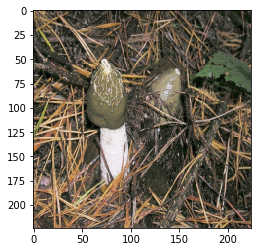

In [48]:
# Show 10 examples of the images, if it's shuffled it shouldn't all be one type

data = allnonflrDat

for i in range(10):
    index = i
    print("Showing %s index image" %(index))
    imgplot = plt.imshow(data[index])
    plt.show()

In [49]:
allflrLbl = np.ones((allflrDat.shape[0]))

In [50]:
allnonflrLbl = np.zeros((allnonflrDat.shape[0]))

In [51]:
print("For the flower and non-flower label datasets:")
print("The shapes are %s, %s" \
      %(allflrLbl.shape, allnonflrLbl.shape))

For the flower and non-flower label datasets:
The shapes are (11250,), (7230,)


In [52]:
trSplit = 0.8
trflr_index = math.floor(trSplit*allflrLbl.shape[0])
trnonflr_index = math.floor(trSplit*allnonflrLbl.shape[0])

print("Indices for %s split is %s and %s" %(trSplit, trflr_index, trnonflr_index))

Indices for 0.8 split is 9000 and 5784


In [53]:
trDat = np.vstack((allflrDat[0:trflr_index,], allnonflrDat[0:trnonflr_index,]))
trLbl = np.concatenate((allflrLbl[0:trflr_index,], allnonflrLbl[0:trnonflr_index,]))
tsDat = np.vstack((allflrDat[trflr_index:,], allnonflrDat[trnonflr_index:,]))
tsLbl = np.concatenate((allflrLbl[trflr_index:,], allnonflrLbl[trnonflr_index:,]))

In [54]:
print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDat.shape, trLbl.shape, tsDat.shape, tsLbl.shape))

For the training and test datasets:
The shapes are (14784, 224, 224, 3), (14784,), (3696, 224, 224, 3), (3696,)


In [55]:
trLbl[trflr_index-2:trflr_index+2]

array([1., 1., 0., 0.])

In [56]:
if additional_data == True:
    np.savez("./npz/flrnonflr-train-imgs" + str(pixel_size) + "-" + str(trSplit) + "+.npz", trDat)
    np.savez("./npz/flrnonflr-train-labels" + str(pixel_size) + "-" + str(trSplit) + "+.npz", trLbl)
    np.savez("./npz/flrnonflr-test-imgs" + str(pixel_size) + "-" + str(trSplit) + "+.npz", tsDat)
    np.savez("./npz/flrnonflr-test-labels" + str(pixel_size) + "-" + str(trSplit) + "+.npz", tsLbl)
else:
    np.savez("./npz/flrnonflr-train-imgs" + str(pixel_size) + "-" + str(trSplit) + ".npz", trDat)
    np.savez("./npz/flrnonflr-train-labels" + str(pixel_size) + "-" + str(trSplit) + ".npz", trLbl)
    np.savez("./npz/flrnonflr-test-imgs" + str(pixel_size) + "-" + str(trSplit) + ".npz", tsDat)
    np.savez("./npz/flrnonflr-test-labels" + str(pixel_size) + "-" + str(trSplit) + ".npz", tsLbl)

In [57]:
count_dict = {}

for label in tsLbl:
    if label in count_dict.keys():
        count_dict[label] += 1
    else:
        count_dict[label] = 1

In [58]:
count_dict

{1.0: 2250, 0.0: 1446}